In [69]:
import os
import json
import random
import pickle
import torch
import torchvision.transforms as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn import svm
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [76]:
furkan_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/images"
gamze_images_dir = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/images"
furkan_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Furkan_Pan/Furkan_Excel.xlsx"
gamze_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/Furkan_Excel.xlsx"
total_excel_path = "/content/drive/MyDrive/Ara_proje_dataset/Total_Excel.xlsx"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = T.Compose([T.ToTensor(),T.Normalize([0.5], [0.5])])
classes = ("Hatasiz" , "Hatali")
new_size = 224

In [3]:
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
dinov2.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 144MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [4]:
def pad_image(image_path,target_size):
  img = Image.open(image_path).convert('RGB')
  resized_img = T.Resize(target_size,max_size=256)(img)
  padding = get_padding_sizes(resized_img,target_size)
  result = T.Pad(padding,0,"constant")(resized_img)
  return result,(image_path,result.size)

def get_padding_sizes(image, target_size):
  width, height = image.size
  hor_pad_size = target_size - width      # yatay olarak padding alanı boyutu
  ver_pad_size = target_size - height     # düşey olarak padding alanı boyutu
  padding_left = hor_pad_size//2
  padding_right = hor_pad_size - padding_left
  padding_top = ver_pad_size//2
  padding_bottom = ver_pad_size - padding_top
  padding = (padding_left,padding_top,padding_right,padding_bottom)
  return padding

def display_pil_image(image_path,new_size=224):
  result = pad_image(image_path,new_size)
  display(result[0])
  return result[1]

def sort_image_list(lst):
  new_lst = []
  extensions = {}
  for i in range(0,len(lst)):
    id = Path(lst[i]).stem
    extensions[id] = lst[i][-4:]
    new_lst.append(int(id))

  new_lst = sorted(new_lst)

  for i in range(0,len(lst)):
    id = str(new_lst[i])
    new_lst[i]= id + extensions[id]
  return new_lst

def display_images_labels(imgs_lst,labels_file):
  new_img_lst = sort_image_list(imgs_lst)
  return pd.DataFrame({
      "image" : [img for img in new_img_lst],
      "id" : [labels_file.iloc[i,0] for i in range(0,len(labels_file))],
      "Hata" : [labels_file.iloc[i,1] for i in range(0,len(labels_file))],
      "Type" : [labels_file.iloc[i,2] for i in range(0,len(labels_file))]
      })

def create_images_list(dir,sort=False,fullPath=False):
  lst = os.listdir(dir)

  if sort:
    lst = sort_image_list(lst)

  if fullPath:
    for i,img in enumerate(lst):
      path = os.path.join(dir,img)
      lst[i] = path

  return lst

def merge_image_directories(dir1,dir2,sort=False,fullPath=False):
  list1 = create_images_list(dir1,sort,fullPath)
  list2 = create_images_list(dir2,sort,fullPath)
  total = list1 + list2
  return total

## Image list must be sorted before call this function.
## Call sort_image_list function
def create_img_label_dict(imgs_lst,labels_lst):
  dict = {}
  for i,img in enumerate(imgs_lst):
    dict[img] = labels_lst.iloc[i,1]
  return dict

def load_image(img,new_size):
  result = pad_image(img,new_size)
  transformed_img = transform(result[0])[:3].unsqueeze(0)
  return transformed_img

def compute_embeddings(img_paths,new_size):
  all_embeddings = {}
  with torch.no_grad():
    for i, file in enumerate(tqdm(img_paths,desc="Processing files")):
      embeddings = dinov2(load_image(file,new_size).to(device))
      all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

  with open("all_embeddings.json", "w") as f:
      f.write(json.dumps(all_embeddings))

  return all_embeddings

In [5]:
total_labels_file = pd.read_excel(total_excel_path,header=None,keep_default_na=False)
imgs_paths = merge_image_directories(furkan_images_dir,gamze_images_dir,sort=True,fullPath=True)
img_label_dict = create_img_label_dict(imgs_paths,total_labels_file)

In [6]:
pd.set_option("display.max_rows",None)
pd.set_option("display.width",None)
display_images_labels(imgs_paths,total_labels_file)

,image,id,Hata,Type
0,1.jpg,1,0,
1,2.jpg,2,1,3
2,3.jpg,3,1,4
3,4.jpg,4,0,
4,5.jpg,5,1,4
5,6.jpg,6,1,5
6,7.jpg,7,1,4
7,9.jpg,9,1,5
8,11.jpg,11,1,5
9,14.jpg,14,0,


In [7]:
embeddings = compute_embeddings(imgs_paths,new_size)

Processing files:   0%|          | 0/1497 [00:00<?, ?it/s]

In [71]:
clf = svm.SVC(probability=True,gamma='scale')

print(f"Embeddings list length: {len(embeddings.values())}")

embedding_list = list(embeddings.values())

x = np.array(embedding_list).reshape(-1,384)
y = []
for i in range(0,len(total_labels_file)):
  y.append(total_labels_file.iloc[i,1])
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=60, stratify=y)
print(f"train dataset length: {len(x_train)} , test dataset length: {len(x_test)}")

Embeddings list length: 1497
train dataset length: 1197 , test dataset length: 300


In [72]:
model = clf.fit(x_train, y_train)

In [73]:
predictions = clf.predict(x_test)
print(classification_report(y_test,predictions,target_names=classes))

              precision    recall  f1-score   support

      Class1       0.61      0.52      0.56       138
      Class2       0.64      0.71      0.67       162

    accuracy                           0.62       300
   macro avg       0.62      0.62      0.62       300
weighted avg       0.62      0.62      0.62       300



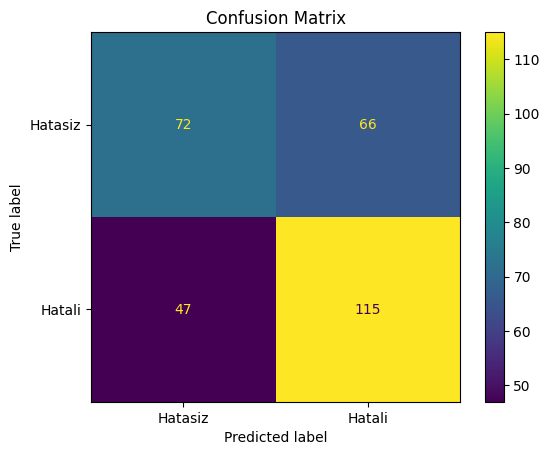

In [77]:
cm = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()

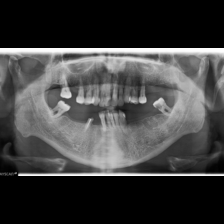

('/content/drive/MyDrive/Ara_proje_dataset/Gamze_Pan/images/2337.jpg', (224, 224))
Hatasiz = 15.25789849996315%
Hatali = 84.74210150003685%
Predicted class: Hatali
Actual class: Hatali


In [83]:
random_image = random.choice(imgs_paths)
print(display_pil_image(random_image))
image = load_image(random_image,new_size)
with torch.no_grad():
  embedding = dinov2(image.to(device))
  arr = np.array(embedding[0].cpu()).reshape(1, -1)
  prediction = clf.predict(arr)
  probability=clf.predict_proba(arr)
for ind,val in enumerate(classes):
  print(f'{val} = {probability[0][ind]*100}%')
print(f"Predicted class: {classes[int(prediction[0])]}")
print(f"Actual class: {classes[int(img_label_dict[random_image])]}")


In [30]:
## Save the model
project_dir = Path("/content/drive/MyDrive/Models/")
project_dir.mkdir(parents=True, exist_ok=True)
with open('/content/drive/MyDrive/Models/dinv2_vit14_model.pth', 'wb') as model_file:
    pickle.dump(model, model_file)